In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
import nltk
from nltk.corpus import stopwords
import gensim
from gensim import corpora
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis
import ast
import re
import string
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import re
import spacy

C:\Users\pdevi\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (
C:\Users\pdevi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,


In [2]:
questions_data_treated_path = "C:/Users/pdevi/OneDrive/Desktop/OpenClassrooms/Project_4/data_questions/BIG_DATA_processed.csv"

data_treated=pd.read_csv(questions_data_treated_path)

data_treated['ProcessedText'] = data_treated['ProcessedText'].apply(ast.literal_eval)

print("Colonnes du jeu de données traité : ", data_treated.columns)

Colonnes du jeu de données traité :  Index(['Id', 'Title', 'ViewCount', 'Score', 'Body', 'Tags', 'CreationDate',
       'AnswerCount', 'FavoriteCount', 'NumTags', 'CleanedTitle',
       'CleanedBody', 'CombinedText', 'ProcessedText'],
      dtype='object')


In [3]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import os
import ast
from collections import Counter
from sklearn.model_selection import train_test_split
import joblib
from scipy.spatial.distance import cdist

# Fonction pour évaluer en toute sécurité une chaîne comme une liste
def safely_evaluate_list(tag_string):
    try:
        return ast.literal_eval(tag_string)
    except (ValueError, SyntaxError):
        return []

# Fonction pour filtrer les tags en fonction des tags sélectionnés
def filter_tags(tags_list, selected_tags):
    filtered_tags = [tag for tag in tags_list if tag in selected_tags]
    return filtered_tags if filtered_tags else None


def calculate_tag_prediction_accuracy(data, processed_text_column, filtered_tags_column):
    correct_tag_predictions = 0
    total_tags = 0

    for _, row in data.iterrows():
        processed_text = row[processed_text_column]
        filtered_tags = row[filtered_tags_column]

        # Count the tags that are actually present in the processed text
        if processed_text and filtered_tags:
            tags_found = [tag for tag in filtered_tags if tag in processed_text]
            correct_tag_predictions += len(tags_found)
            total_tags += len(filtered_tags)

    # Calculate the proportion of tags present in the text
    accuracy = correct_tag_predictions / total_tags if total_tags > 0 else 0
    return accuracy

# Charger les données traitées
questions_data_treated_path = "C:/Users/pdevi/OneDrive/Desktop/OpenClassrooms/Project_4/data_questions/BIG_DATA_processed.csv"
data_treated = pd.read_csv(questions_data_treated_path)

# Compter les occurrences des tags après avoir filtré les tags indésirables
all_tags = data_treated['Tags'].apply(safely_evaluate_list).explode()
tag_counts = Counter(all_tags)

# Générer plusieurs configurations pour les 15 et 50 tags les plus fréquents
common_tags_configs = {
    'top_15': set([tag for tag, count in tag_counts.most_common(15)]),
    'top_50': set([tag for tag, count in tag_counts.most_common(50)])
}

global common_tags_configs

# Appliquer le filtrage pour chaque configuration
filtered_datasets = {}
for config_name, selected_tags in common_tags_configs.items():
    data_filtered = data_treated.copy()
    data_filtered['Tags'] = data_filtered['Tags'].apply(safely_evaluate_list)
    data_filtered['FilteredTags'] = data_filtered['Tags'].apply(lambda x: filter_tags(x, selected_tags))
    data_filtered = data_filtered.dropna(subset=['FilteredTags'])
    
    # Filtrer les résultats de la PCA pour correspondre au jeu de données filtré
    index_filtered = data_filtered.index
    
    filtered_datasets[config_name] = data_filtered


# Example usage
for config_name, selected_tags in common_tags_configs.items():
    data_filtered = filtered_datasets[config_name]
    accuracy = calculate_tag_prediction_accuracy(data_filtered, 'ProcessedText', 'FilteredTags')
    print(f"Tag prediction accuracy for {config_name}: {accuracy:.2f}")


Tag prediction accuracy for top_15: 0.57
Tag prediction accuracy for top_50: 0.54


## Entraînement d'un modèle LDA optimisé avec 15 sujets ajustés.

In [3]:
# Créer le dictionnaire et le corpus
dictionary = corpora.Dictionary(data_treated['ProcessedText'])
corpus = [dictionary.doc2bow(text) for text in data_treated['ProcessedText']]

# Entraîner le modèle LDA avec des paramètres ajustés
num_topics = 15  # Définir un nombre de sujets proche du nombre de tags uniques
lda_model = gensim.models.LdaModel(
    corpus, 
    num_topics=num_topics, 
    id2word=dictionary, 
    passes=20,  # Augmenter le nombre de passes pour améliorer l'ajustement du modèle
    alpha='auto',  # Ou expérimenter avec alpha=0.1
    eta=0.002  # Réduire eta pour rendre les sujets plus distincts
)


## Visualiser les sujets LDA en 2D.

Les sujets ont été créés ! 
 
La PCA a été réalisée !
 


C:\Users\pdevi\anaconda3\Lib\site-packages\sklearn\manifold\_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


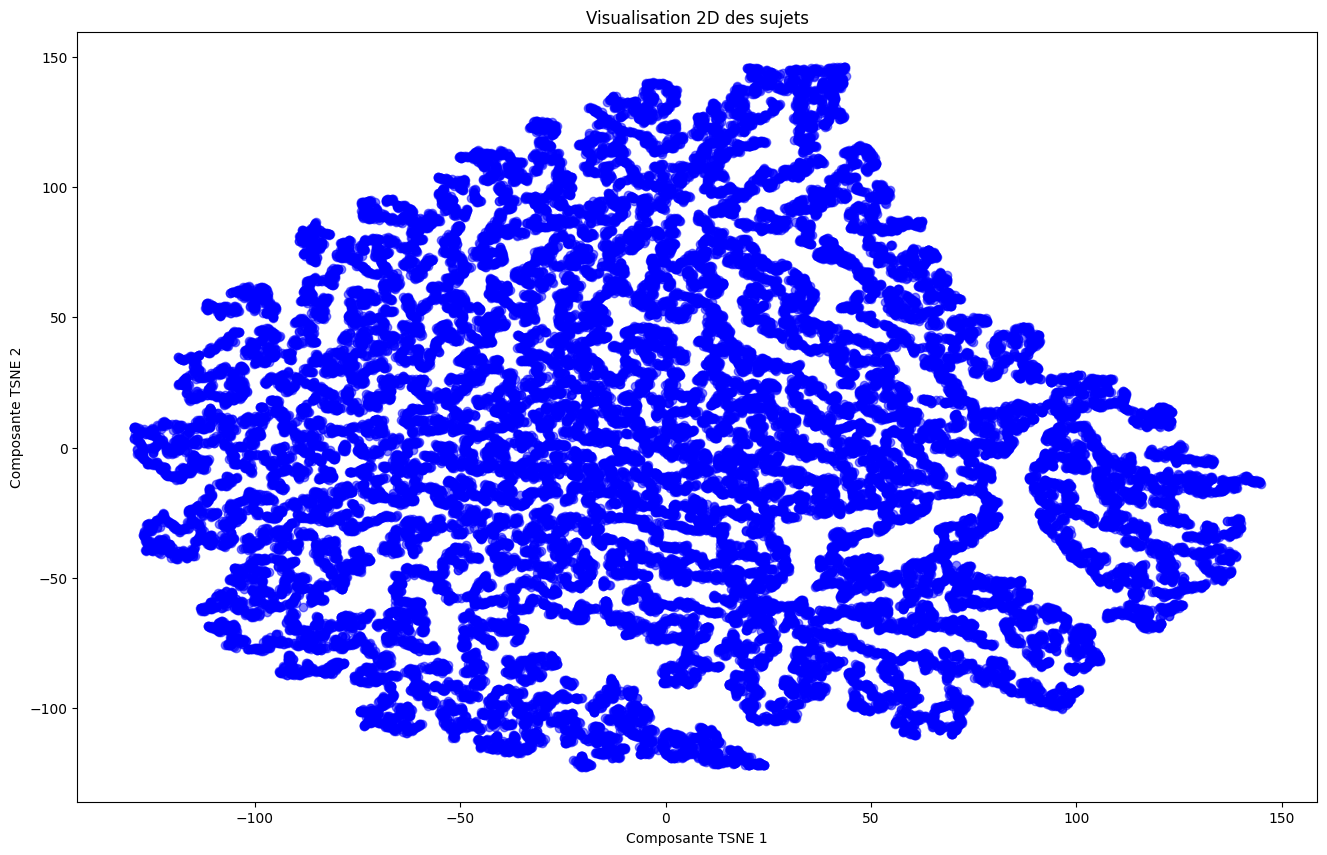

In [4]:
# Obtenir la distribution des sujets pour chaque document
topic_distributions = lda_model.get_document_topics(corpus, minimum_probability=0)

# Convertir les distributions des sujets en DataFrame
topic_df = pd.DataFrame([{i: prob for i, prob in doc} for doc in topic_distributions]).fillna(0)
print("Les sujets ont été créés ! ")
print(" ")

# Effectuer une PCA pour réduire les dimensions avant t-SNE
pca_model = PCA(n_components=2)
pca_results = pca_model.fit_transform(topic_df.values)

print("La PCA a été réalisée !")
print(" ")

# Effectuer le t-SNE pour une visualisation en 2D
tsne_model = TSNE(n_components=2, perplexity=30, random_state=42, n_iter=1000)
tsne_results = tsne_model.fit_transform(pca_results)

# Tracer les résultats
plt.figure(figsize=(16, 10))
plt.scatter(tsne_results[:, 0], tsne_results[:, 1], c='blue', alpha=0.5)
plt.title('Visualisation 2D des sujets')
plt.xlabel('Composante TSNE 1')
plt.ylabel('Composante TSNE 2')
plt.show()


In [5]:
# Importer la bibliothèque pour la visualisation des modèles LDA
import pyLDAvis.gensim

# Activer la visualisation dans le notebook
pyLDAvis.enable_notebook()

# Préparer la visualisation interactive du modèle LDA
vis = pyLDAvis.gensim.prepare(lda_model, corpus, dictionary=lda_model.id2word)

# Afficher la visualisation
vis


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5     -0.025972  0.104843       1        1  13.279880
13     0.170722  0.045542       2        1  10.558342
4     -0.002613  0.110430       3        1   9.877240
10    -0.204962  0.088836       4        1   9.083508
7      0.230259  0.018043       5        1   7.685512
2      0.038457  0.121543       6        1   7.275938
3     -0.190150  0.020140       7        1   6.409495
9     -0.237240  0.054014       8        1   6.216773
6      0.180249  0.071896       9        1   5.817539
1     -0.089373  0.035165      10        1   5.212638
12     0.235816  0.059517      11        1   5.106441
11    -0.041896  0.064751      12        1   4.991309
8     -0.096216 -0.124234      13        1   3.278880
14    -0.011050 -0.320776      14        1   2.744310
0      0.043970 -0.349712      15        1   2.462196, topic_info=          Term           Freq          Total Category  logprob  loglift
118       file  101850.000000  101850.000000  Default  30.0000  30.0000
121       line   68114.000000   68114.000000  Default  29.0000  29.0000
123     python   64838.000000   64838.000000  Default  28.0000  28.0000
260        def   40392.000000   40392.000000  Default  27.0000  27.0000
860      image   25091.000000   25091.000000  Default  26.0000  26.0000
...        ...            ...            ...      ...      ...      ...
607   keyerror     768.702097    1077.383636  Topic15  -4.7241   3.3665
717       path    1440.335925    9035.655718  Topic15  -4.0962   1.8678
3942      edge     612.685272    1559.613742  Topic15  -4.9510   2.7698
3112     store     518.915289    1110.097808  Topic15  -5.1171   2.9437
1090    source     537.475377    5804.448461  Topic15  -5.0819   1.3246

[867 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
2340       7  0.999810       3d
5835       8  0.998856       a1
10432     12  1.000970       ac
5426      10  1.000516      acc
1160       1  0.390322   access
...      ...       ...      ...
2725       4  0.995511     zero
2725       8  0.004652     zero
855        5  0.078145      zip
855       12  0.921617      zip
12688      2  0.999644  zipfile

[1633 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 14, 5, 11, 8, 3, 4, 10, 7, 2, 13, 12, 9, 15, 1])

## Algorithme LDA

### Description du Code

Ce code ci-dessous a pour objectif de prédire automatiquement les **tags** associés à des questions en utilisant un modèle de **Latent Dirichlet Allocation (LDA)**, une technique de modélisation de sujets pour les données textuelles.

#### Étapes Principales :

1. **Chargement des Données** :
   - Lecture des données prétraitées à partir d'un fichier CSV.
   - Extraction et comptage des tags associés à chaque question.

2. **Préparation des Configurations de Tags** :
   - Identification des tags les plus fréquents dans le jeu de données.
   - Création de configurations basées sur les **15** et **50** tags les plus courants.
   - Filtrage des questions pour ne conserver que celles associées aux tags sélectionnés.

3. **Préparation du Modèle LDA** :
   - Conversion des textes prétraités en représentations numériques (Bag-of-Words).
   - Création d'un **dictionnaire** et d'un **corpus** à partir des données d'entraînement.

4. **Entraînement du Modèle LDA** :
   - Entraînement du modèle LDA avec un nombre de sujets égal au nombre de tags sélectionnés.
   - Sauvegarde du modèle entraîné et du dictionnaire pour une utilisation ultérieure.

5. **Prédiction des Tags** :
   - Application du modèle LDA sur les données de test pour obtenir les distributions de sujets.
   - Extraction des mots clés les plus probables pour chaque sujet.
   - Filtrage des mots clés pour ne conserver que ceux présents dans les tags existants.
   - Attribution des tags prédits en fonction des mots clés les plus pertinents.

6. **Évaluation du Modèle** :
   - Calcul de la **précision moyenne** en comparant les tags prédits aux tags réels.
   - Calcul de la **couverture des tags** pour mesurer la proportion de tags uniques correctement prédits.
   - Affichage des résultats pour chaque configuration de tags (top 15 et top 50).

---

Ce code permet d'**évaluer l'efficacité du modèle LDA** pour la prédiction automatique de tags à partir de données textuelles. En explorant différentes configurations basées sur les tags les plus fréquents, il fournit des métriques de performance essentielles pour l'**attribution automatique de tags** dans des systèmes de gestion de contenu ou des plateformes de questions-réponses.

In [5]:
import numpy as np
import os
from gensim import corpora
import gensim
import joblib
from collections import Counter
from sklearn.model_selection import train_test_split

# Définir la fonction pour évaluer en toute sécurité une chaîne comme une liste
def safely_evaluate_list(tag_string):
    try:
        return ast.literal_eval(tag_string)
    except (ValueError, SyntaxError):
        return []

# Fonction pour filtrer les tags en fonction des tags sélectionnés
def filter_tags(tags_list, selected_tags):
    filtered_tags = [tag for tag in tags_list if tag in selected_tags]
    return filtered_tags if filtered_tags else None

# Charger les données traitées
questions_data_treated_path = "C:/Users/pdevi/OneDrive/Desktop/OpenClassrooms/Project_4/data_questions/BIG_DATA_processed.csv"
data_treated = pd.read_csv(questions_data_treated_path)

# Compter les occurrences des tags après avoir filtré les tags indésirables
all_tags = data_treated['Tags'].apply(safely_evaluate_list).explode()
tag_counts = Counter(all_tags)

# Générer plusieurs configurations pour les 10, 15, 20, 25 tags les plus fréquents
common_tags_configs = {
    'top_15': set([tag for tag, count in tag_counts.most_common(15)]),
    'top_50': set([tag for tag, count in tag_counts.most_common(50)])    
}

# Définir le répertoire pour enregistrer les modèles
save_dir_model = "C:/Users/pdevi/OneDrive/Desktop/OpenClassrooms/Project_4/lda_models"

# Fonction pour prédire les tags en utilisant le modèle LDA ajusté et les filtrer par les tags existants
def get_lda_tags_with_filtering(text, lda_model, dictionary, existing_tags, num_tags_to_predict):
    bow = dictionary.doc2bow(text)
    topics = lda_model.get_document_topics(bow, minimum_probability=0.0)

    # Trier les sujets par leur contribution au document
    sorted_topics = sorted(topics, key=lambda x: x[1], reverse=True)

    # Rassembler les mots les plus importants à travers les sujets les plus pertinents
    word_probabilities = {}
    for topic_id, topic_prob in sorted_topics:
        topic_words = lda_model.show_topic(topic_id, topn=50)  # Commencer avec un grand nombre fixe de tags
        for word, prob in topic_words:
            if word in word_probabilities:
                word_probabilities[word] += topic_prob * prob
            else:
                word_probabilities[word] = topic_prob * prob

    # Filtrer les mots pour ne garder que ceux qui sont dans les tags existants
    filtered_words = {word: prob for word, prob in word_probabilities.items() if word in existing_tags}

    # Trier les mots filtrés par leurs probabilités pondérées combinées
    sorted_words = sorted(filtered_words.items(), key=lambda x: x[1], reverse=True)

    # Sélectionner les meilleurs mots comme tags prédits, en correspondant au nombre de tags réels
    predicted_tags = [word for word, prob in sorted_words[:num_tags_to_predict]]
    return predicted_tags

# Fonction pour entraîner et évaluer le modèle LDA
def train_and_evaluate_lda(train_data, test_data, num_topics, save_dir, config_name):
    # Créer le dictionnaire et le corpus pour le jeu d'entraînement
    dictionary = corpora.Dictionary(train_data['ProcessedText'])
    corpus = [dictionary.doc2bow(text) for text in train_data['ProcessedText']]

    # Entraîner le modèle LDA
    lda_model = gensim.models.LdaModel(
        corpus,
        num_topics=num_topics,
        id2word=dictionary,
        passes=10,
        alpha='auto',
        eta=0.01
    )

    # Enregistrer le modèle LDA et le dictionnaire
    lda_model.save(os.path.join(save_dir, f'lda_model_{config_name}.model'))
    dictionary.save(os.path.join(save_dir, f'lda_dictionary_{config_name}.dict'))

    # Obtenir tous les tags uniques dans le jeu de données pour filtrer les tags prédits
    unique_tags = set(tag for tags in train_data['FilteredTags'] for tag in tags)

    # Appliquer la fonction au jeu de test
    test_data['PredictedTags'] = test_data.apply(
        lambda row: get_lda_tags_with_filtering(
            row['ProcessedText'], lda_model, dictionary, unique_tags, len(row['FilteredTags'])
        ),
        axis=1
    )

    # Ajouter une colonne pour le nombre de tags réels
    test_data['NumberOfRealTags'] = test_data['FilteredTags'].apply(len)

    # Fonction pour calculer la précision basée sur la correspondance de sous-chaînes
    def calculate_accuracy(real_tags, predicted_tags):
        correct_predictions = 0
        for predicted_tag in predicted_tags:
            if any(predicted_tag in real_tag for real_tag in real_tags):
                correct_predictions += 1
        return min(correct_predictions / len(real_tags), 1)

    # Fonction pour calculer la couverture des tags basée sur la nouvelle logique
    def calculate_tag_coverage(data_subset, all_tags):
        covered_tags = set()
        for _, row in data_subset.iterrows():
            real_tags = row['FilteredTags']
            predicted_tags = row['PredictedTags']
            for real_tag in real_tags:
                if any(real_tag in predicted_tag for predicted_tag in predicted_tags):
                    covered_tags.add(real_tag)
        # Calculer la couverture comme le ratio des tags couverts sur le nombre total de tags uniques
        coverage = len(covered_tags) / len(all_tags)
        return coverage

    # Calculer la précision pour chaque document
    test_data['Accuracy'] = test_data.apply(
        lambda row: calculate_accuracy(row['FilteredTags'], row['PredictedTags']), axis=1
    )

    # Calculer la couverture globale pour le jeu de test
    overall_coverage = calculate_tag_coverage(test_data, unique_tags)

    # Calculer la précision globale pour le jeu de test
    overall_accuracy = test_data['Accuracy'].mean()

    print(f'Config: {config_name}')
    print(f'Overall Accuracy: {overall_accuracy:.2f}')
    print(f'Overall Tag Coverage: {overall_coverage:.2f}')
    # Exemple d'utilisation de la fonction

    return lda_model, dictionary, overall_accuracy, overall_coverage

# Appliquer le filtrage pour chaque configuration et entraîner/évaluer le modèle LDA
for config_name, selected_tags in common_tags_configs.items():
    # Filtrer le jeu de données
    data_filtered = data_treated.copy()
    data_filtered['Tags'] = data_filtered['Tags'].apply(safely_evaluate_list)
    data_filtered['FilteredTags'] = data_filtered['Tags'].apply(
        lambda x: filter_tags(x, selected_tags)
    )
    data_filtered = data_filtered.dropna(subset=['FilteredTags'])

    # Séparer les données en jeu d'entraînement et jeu de test
    train_data, test_data = train_test_split(
        data_filtered, test_size=0.2, random_state=42
    )
    train_data['ProcessedText'] = train_data['ProcessedText'].apply(safely_evaluate_list)
    test_data['ProcessedText'] = test_data['ProcessedText'].apply(safely_evaluate_list)
    # Définir le nombre de sujets égal au nombre de tags les plus communs
    num_topics = len(selected_tags)

    # Entraîner et évaluer le modèle LDA
    train_and_evaluate_lda(
        train_data, test_data, num_topics, save_dir_model, config_name
    )


Config: top_15
Overall Accuracy: 0.50
Overall Tag Coverage: 0.73
Config: top_50
Overall Accuracy: 0.37
Overall Tag Coverage: 0.62


## Algorithme KMeans

### Description du Code

Ce code a pour objectif de prédire automatiquement les **tags** associés à des questions en utilisant l'algorithme de **clustering KMeans** sur des données textuelles prétraitées et réduites en dimensions grâce à une **Analyse en Composantes Principales (ACP)**.

#### Étapes Principales :

1. **Chargement des Données** :
   - Importation des questions prétraitées depuis un fichier CSV.
   - Chargement des résultats de l'ACP appliquée aux embeddings textuels pour réduire la dimensionnalité.

2. **Préparation des Tags** :
   - Calcul des tags les plus fréquents dans l'ensemble de données.
   - Création de configurations basées sur les **15** et **50** tags les plus communs.
   - Filtrage des données pour ne conserver que les questions associées aux tags sélectionnés.

3. **Application de KMeans** :
   - Séparation des données filtrées en ensembles d'**entraînement** et de **test**.
   - Entraînement du modèle **KMeans** sur les données d'entraînement pour créer des clusters.
   - Attribution d'un nom à chaque cluster en utilisant le tag le plus fréquent parmi les données du cluster.

4. **Prédiction des Tags** :
   - Calcul des distances des données de test aux centres des clusters.
   - Prédiction des tags pour chaque question en fonction des clusters les plus proches.

5. **Évaluation du Modèle** :
   - Calcul de la **précision moyenne** des prédictions en comparant les tags prédits aux tags réels.
   - Calcul de la **couverture des tags** pour évaluer la proportion de tags uniques correctement prédits au moins une fois en considérant toutes       les données.
   - Sélection du **meilleur modèle** basé sur la précision la plus élevée.

6. **Sauvegarde du Meilleur Modèle** :
   - Sauvegarde du modèle KMeans avec les meilleures performances pour une utilisation future.
   - Enregistrement des noms des clusters et des métriques de performance (précision et couverture).

---

Ce code permet d'**évaluer l'efficacité du clustering non supervisé** pour la prédiction automatique de tags sur des données textuelles. Il explore différentes configurations basées sur les tags les plus fréquents et mesure les performances du modèle en termes de précision et de couverture, offrant ainsi une solution pour l'**attribution automatique de tags** dans des systèmes de gestion de contenu ou des plateformes de questions-réponses.

In [23]:
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import numpy as np
import os
import ast
from collections import Counter
from sklearn.model_selection import train_test_split
import joblib
from scipy.spatial.distance import cdist

# Fonction pour évaluer en toute sécurité une chaîne comme une liste
def safely_evaluate_list(tag_string):
    try:
        return ast.literal_eval(tag_string)
    except (ValueError, SyntaxError):
        return []

# Fonction pour filtrer les tags en fonction des tags sélectionnés
def filter_tags(tags_list, selected_tags):
    filtered_tags = [tag for tag in tags_list if tag in selected_tags]
    return filtered_tags if filtered_tags else None

# Charger les données traitées
questions_data_treated_path = "C:/Users/pdevi/OneDrive/Desktop/OpenClassrooms/Project_4/data_questions/BIG_DATA_processed.csv"
data_treated = pd.read_csv(questions_data_treated_path)

# Charger les résultats de la PCA
save_dir = "C:\\Users\\pdevi\\OneDrive\\Desktop\\OpenClassrooms\\Project_4\\embeddings_data"
pca_results_save_path = os.path.join(save_dir, "pca_results.npy")
pca_results = np.load(pca_results_save_path, allow_pickle=True).item()

# Compter les occurrences des tags après avoir filtré les tags indésirables
all_tags = data_treated['Tags'].apply(safely_evaluate_list).explode()
tag_counts = Counter(all_tags)

# Générer plusieurs configurations pour les 15 et 50 tags les plus fréquents
common_tags_configs = {
    'top_15': set([tag for tag, count in tag_counts.most_common(15)]),
    'top_50': set([tag for tag, count in tag_counts.most_common(50)])
}

# Appliquer le filtrage pour chaque configuration
filtered_datasets = {}
filtered_pca_results = {}
for config_name, selected_tags in common_tags_configs.items():
    data_filtered = data_treated.copy()
    data_filtered['Tags'] = data_filtered['Tags'].apply(safely_evaluate_list)
    data_filtered['FilteredTags'] = data_filtered['Tags'].apply(lambda x: filter_tags(x, selected_tags))
    data_filtered = data_filtered.dropna(subset=['FilteredTags'])
    
    # Filtrer les résultats de la PCA pour correspondre au jeu de données filtré
    index_filtered = data_filtered.index
    pca_filtered = {feature_name: X[index_filtered] for feature_name, X in pca_results.items()}
    
    filtered_datasets[config_name] = data_filtered
    filtered_pca_results[config_name] = pca_filtered

save_dir_model = "C:/Users/pdevi/OneDrive/Desktop/OpenClassrooms/Project_4/API"

# Fonction modifiée pour afficher la précision et la couverture des tags pour chaque configuration et ensemble de caractéristiques
def apply_kmeans_predict_tags(train_data, test_data, features_train, features_test, processed_text_column, save_dir_model, config_name, feature_name, num_tags_pred=None):
    valid_tags = set(train_data['FilteredTags'].explode().unique())
    num_clusters = len(valid_tags)
    
    if num_clusters == 0:
        raise ValueError("Aucun tag valide trouvé dans les données d'entraînement.")
    
    # Si le nombre de clusters est supérieur au nombre de tags valides, le réduire
    if num_clusters > len(valid_tags):
        num_clusters = len(valid_tags)
    
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    kmeans.fit(features_train)
    
    # Sauvegarder le modèle KMeans
    kmeans_model_path = os.path.join(save_dir_model, 'best_kmeans_model.pkl')
    joblib.dump(kmeans, kmeans_model_path)
    
    # Prédire les clusters pour les données de test
    cluster_labels_train = kmeans.predict(features_train)
    distances_to_clusters = cdist(features_test, kmeans.cluster_centers_, metric='euclidean')
    
    # Créer un DataFrame pour mapper les clusters au texte traité
    cluster_data_map = pd.DataFrame({'Cluster': cluster_labels_train, 'ProcessedText': train_data[processed_text_column]})
    
    # Initialiser un dictionnaire pour suivre les noms attribués
    assigned_names = {}
    
    # Attribuer le tag valide le plus commun dans chaque cluster comme nom de cluster
    cluster_names = []
    for i in range(num_clusters):
        cluster_data = cluster_data_map[cluster_data_map['Cluster'] == i]
        token_list = [word for tokens in cluster_data['ProcessedText'] for word in tokens.split() if word in valid_tags]
        word_counts = Counter(token_list).most_common()
        
        if word_counts:
            for word, count in word_counts:
                if word not in assigned_names:
                    assigned_names[word] = (i, count)
                    cluster_names.append(word)
                    break
        else:
            cluster_names.append(None)
    
    # Réattribuer les noms de clusters qui sont None
    for idx, name in enumerate(cluster_names):
        if name is None:
            remaining_tags = valid_tags - set(assigned_names.keys())
            if remaining_tags:
                cluster_names[idx] = remaining_tags.pop()
                assigned_names[cluster_names[idx]] = (idx, 1)
    
    test_data['DistancesToClusters'] = list(distances_to_clusters)
    test_data['SortedClusters'] = test_data['DistancesToClusters'].apply(lambda x: np.argsort(x))
    
    def get_sorted_predicted_tags(row, num_tags_pred):
        sorted_clusters = row['SortedClusters']
        if num_tags_pred is None:
            num_tags_pred = len(row['FilteredTags'])
        predicted_tags = [cluster_names[cluster] for cluster in sorted_clusters[:num_tags_pred]]
        return predicted_tags
    
    test_data['PredictedTags'] = test_data.apply(lambda row: get_sorted_predicted_tags(row, num_tags_pred), axis=1)
    
    accuracy_list = []

    def calculate_accuracy(real_tags, predicted_tags):
        correct_predictions = 0
        for predicted_tag in predicted_tags:
            if any(predicted_tag in real_tag for real_tag in real_tags):
                correct_predictions += 1
        return correct_predictions / len(real_tags) if len(predicted_tags) > 0 else 0

    all_tags = set(tag for tags in test_data['FilteredTags'] for tag in tags)
    
    covered_tags = set()

    for idx, row in test_data.iterrows():
        true_tags = row['FilteredTags']
        pred_tags = row['PredictedTags']
        
        accuracy_list.append(calculate_accuracy(true_tags, pred_tags))
        for real_tag in true_tags:
            if any(real_tag in predicted_tag for predicted_tag in pred_tags):
                covered_tags.add(real_tag)

    accuracy = np.mean(accuracy_list)
    coverage = len(covered_tags) / len(all_tags)

    print(f"Configuration: {config_name}, Caractéristique: {feature_name}")
    print(f"Précision : {accuracy:.2f}, Couverture des tags : {coverage:.2f}")
    print("-" * 50)

    return {
        'model': kmeans,
        'cluster_names': cluster_names,
        'accuracy': accuracy,
        'coverage': coverage
    }

# Collecter les métriques pour une table récapitulative
results = []

for config_name, selected_tags in common_tags_configs.items():
    train_data, test_data = train_test_split(filtered_datasets[config_name], test_size=0.2, random_state=42)
    
    for feature_name, features in filtered_pca_results[config_name].items():
        print(f"Traitement de {feature_name} dans {config_name}...")
        
        features_train, features_test = train_test_split(features, test_size=0.2, random_state=42)
        
        # KMeans avec 5 tags prédits
        model_info_fixed = apply_kmeans_predict_tags(train_data, test_data, features_train, features_test, 'ProcessedText', save_dir_model, config_name, feature_name, num_tags_pred=5)
        
        results.append({
            'config_name': config_name,
            'feature_name': feature_name,
            'accuracy': model_info_fixed['accuracy'],
            'coverage': model_info_fixed['coverage']
        })
        
        # KMeans avec le nombre de tags réels
        model_info_real = apply_kmeans_predict_tags(train_data, test_data, features_train, features_test, 'ProcessedText', save_dir_model, config_name, feature_name)
        
        results.append({
            'config_name': config_name,
            'feature_name': feature_name,
            'accuracy': model_info_real['accuracy'],
            'coverage': model_info_real['coverage']
        })

# Créer un DataFrame et afficher la table récapitulative des résultats
results_df = pd.DataFrame(results)
print("\nTableau récapitulatif :")
print(results_df)

# Optionnellement sauvegarder les résultats en CSV
results_csv_path = os.path.join(save_dir_model, 'kmeans_results_summary.csv')
results_df.to_csv(results_csv_path, index=False)

print(f"Résultats sauvegardés dans {results_csv_path}")

Traitement de BoW dans top_15...
Configuration: top_15, Caractéristique: BoW
Précision : 0.46, Couverture des tags : 0.93
--------------------------------------------------
Configuration: top_15, Caractéristique: BoW
Précision : 0.11, Couverture des tags : 0.93
--------------------------------------------------
Traitement de TF-IDF dans top_15...
Configuration: top_15, Caractéristique: TF-IDF
Précision : 0.42, Couverture des tags : 1.00
--------------------------------------------------
Configuration: top_15, Caractéristique: TF-IDF
Précision : 0.11, Couverture des tags : 1.00
--------------------------------------------------
Traitement de Word2Vec dans top_15...
Configuration: top_15, Caractéristique: Word2Vec
Précision : 0.33, Couverture des tags : 0.93
--------------------------------------------------
Configuration: top_15, Caractéristique: Word2Vec
Précision : 0.08, Couverture des tags : 0.93
--------------------------------------------------
Traitement de Doc2Vec dans top_15...
